In [1]:
cd ..

/home/tommy/Scrivania/Polimi/Honours Programme/SCFR


In [198]:
from os import listdir, path
import json
import matplotlib.pyplot as plt

from data_structures.cfr_trees import CFRTree
from games.goofspiel import build_goofspiel_tree
from games.kuhn import build_kuhn_tree
from games.leduc import build_leduc_tree
from functools import reduce

In [199]:
def parameters_to_string(par):
    if(par['game'] == 'kuhn'):
        return 'kuhn_' + str(par['players']) + '_' + str(par['rank'])
    if(par['game'] == 'leduc'):
        return 'leduc_' + str(par['players']) + '_' + str(par['suits']) + '_' + str(par['rank'])
    if(par['game'] == 'goofspiel'):
        return 'goofspiel_' + str(par['players']) + '_' + str(par['rank']) + '_' + str(par['tie_solver'])
    if(par['game'] == 'random'):
        return 'random_' + str(par['players']) + '_' + str(par['depth']) + '_' + str(par['branching_factor'])

In [200]:
# TODO: check it, in particular for bigger versions of goofspiel
# TODO: implement different goofspiel TieSolver

def delta_utility(game, players, rank, betting_parameters = [2, 4]):
    if game == 'kuhn':
        return 2 * players
    if game == 'leduc':
        return players + players * betting_parameters[0] + players * betting_parameters[1]
    if game == 'goofspiel':
        return sum(list(range(1, rank+1)))
    if game == 'random':
        return 1

In [201]:
def max_social_welfare(game, players, rank, betting_parameters = [2, 4]):
    if game == 'kuhn' or game == 'leduc':
        return 0
    if game == 'goofspiel':
        return sum(list(range(1, rank+1)))
    if game == 'random':
        return players

In [235]:
target_directory = "results/remote/goofspiel_20190121/"

In [236]:
file_names = listdir(target_directory)

In [237]:
def analyze(name, target_epsilons, data_per_instance):
    if path.isdir(target_directory + name):
        return
    
    file = open(target_directory + name, "r")
    data = json.load(file)
    
    print("File = " + name)
    print("Game = " + parameters_to_string(data['parameters']))
    
    print("Total iterations = " + str(data['parameters']['number_iterations']))
    print("Check every iteration = " + str(data['parameters']['check_every_iteration']))
    
    # --------- SKIP 2 PLAYERS LEDUC AND GOOFSPIEL ---------
    if data['parameters']['game'] in ['goofspiel', 'leduc'] and data['parameters']['players'] == 2:
        print("---------------------------")
        print("Skipping 2 player versions")
        print("---------------------------")
        print("")
        return
    # ------------------------------------------------------
    
    durations = list(map(lambda el: el['duration'], data['data']))
    
    target_datapoint_amount = int(data['parameters']['number_iterations']) / int(data['parameters']['check_every_iteration'])
    run_time = sum(durations)
    avg_time = run_time / len(durations)
    print("Logged " + str(len(data['data'])) + " out of " + str(target_datapoint_amount) + " datapoints in " + \
          str(run_time) + " seconds (aka " + str(run_time/3600) + " hours)")
    print("Average duration of batch = " + str(avg_time) + " seconds (aka " + str(avg_time/3600) + " hours)")

    if 'total_duration' in data:
        running_time = data['total_duration']
        print("Solved in " + str(running_time) + " seconds")
        print("Solved in " + str(running_time / 60) + " minutes")
        print("Solved in " + str(running_time / 3600) + " hours")
        
    if 'utility' in data:
        u = data['utility']
        sw = sum(u)
        print("Final utility = " + str(u))
        print("Social welfare = " + str(sw))
        max_sw = max_social_welfare(data['parameters']['game'], data['parameters']['players'], 
                                    data['parameters']['rank'], data['parameters']['betting_parameters'])
        if max_sw != 0:
            print("Max social welfare = " + str(max_sw) + " (obtained " + \
                  str(sw / max_sw * 100) + "%)")

    if 'total_duration' in data:
        print("Average iterations per second = " + str(data['average_iterations_per_second']))
    
    du = delta_utility(data['parameters']['game'], data['parameters']['players'], data['parameters']['rank'],
                   data['parameters']['betting_parameters'])

    iteration_counts = list(map(lambda el: el['iteration_number'], data['data']))
    epsilons = list(map(lambda el: max(0, -min(el['epsilon'])), data['data']))
    percent_epsilons = list(map(lambda el: el / du, epsilons))
    #absolute_joint_sizes = list(map(lambda el: el['absolute_joint_size'], data['data']))
    #relative_joint_sizes = list(map(lambda el: el['relative_joint_size'], data['data']))
    #max_plan_frequencies = list(map(lambda el: el['max_plan_frequency'], data['data']))
    #joint_support_sizes = list(map(lambda el: el['joint_support_size'], data['data']))
    
    plt.plot(iteration_counts, epsilons)
    plt.show()
    plt.plot(iteration_counts, percent_epsilons)
    plt.show()
    
    time_to_target = []
    iterations_to_target = []
    
    for t in target_epsilons:
        indices_below_t = [i for i in range(len(epsilons)) if percent_epsilons[i] <= t]
        if len(indices_below_t) > 0:
            time_to_t = sum(durations[:indices_below_t[0]+1])
            iterations_to_target.append((indices_below_t[0]+1) * int(data['parameters']['check_every_iteration']))
        else:
            time_to_t = -1
            iterations_to_target.append(-1)
        time_to_target.append(round(time_to_t, 5))
    
    s = parameters_to_string(data['parameters'])
    while s in data_per_instance:
        s += '_'
    data_per_instance[s] = {'time_to_target': time_to_target,
                            'iterations_to_target': iterations_to_target,
                            'parameters': data['parameters']}

File = 1547916481_2_5
Game = goofspiel_2_5_discard_always
Total iterations = 10000
Check every iteration = 10
---------------------------
Skipping 2 player versions
---------------------------

File = 1547830530_3_3
Game = goofspiel_3_3_accumulate
Total iterations = 100000
Check every iteration = 100
Logged 1000 out of 1000.0 datapoints in 23671.153594493866 seconds (aka 6.575320442914963 hours)
Average duration of batch = 23.671153594493866 seconds (aka 0.0065753204429149625 hours)
Solved in 23692.33481144905 seconds
Solved in 394.8722468574842 minutes
Solved in 6.581204114291403 hours
Final utility = [1.510300000002195, 1.8592899999970893, 2.629951666667211]
Social welfare = 5.999541666666495
Max social welfare = 6 (obtained 99.99236111110825%)
Average iterations per second = 4.220774389515893


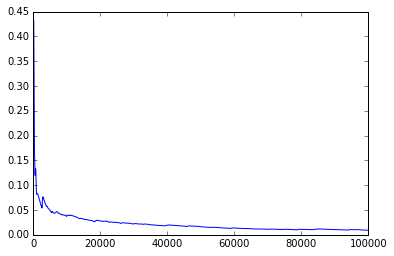

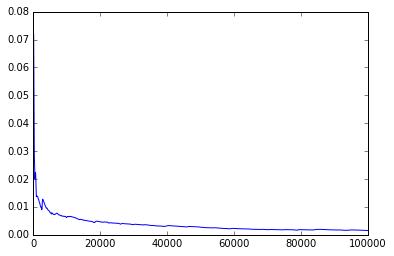

File = 1547830201_2_2
Game = goofspiel_2_2_discard_always
Total iterations = 100000
Check every iteration = 100
---------------------------
Skipping 2 player versions
---------------------------

File = 1547830544_3_3
Game = goofspiel_3_3_discard_if_high
Total iterations = 100000
Check every iteration = 100
Logged 1000 out of 1000.0 datapoints in 20893.96160507202 seconds (aka 5.803878223631117 hours)
Average duration of batch = 20.893961605072022 seconds (aka 0.005803878223631117 hours)
Solved in 20916.014229774475 seconds
Solved in 348.60023716290794 minutes
Solved in 5.810003952715132 hours
Final utility = [1.4935616666691587, 2.4852133333309046, 1.9916349999963538]
Social welfare = 5.970409999996417
Max social welfare = 6 (obtained 99.50683333327362%)
Average iterations per second = 4.781025624741041


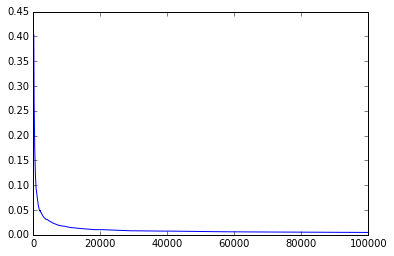

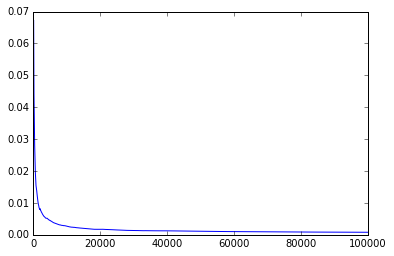

File = 1547830211_2_3
Game = goofspiel_2_3_discard_always
Total iterations = 100000
Check every iteration = 100
---------------------------
Skipping 2 player versions
---------------------------

File = 1547904068_3_4
Game = goofspiel_3_4_discard_always
Total iterations = 10000
Check every iteration = 10
Logged 1000 out of 1000.0 datapoints in 69827.1253824234 seconds (aka 19.396423717339832 hours)
Average duration of batch = 69.8271253824234 seconds (aka 0.019396423717339833 hours)
Solved in 69839.96318864822 seconds
Solved in 1163.9993864774704 minutes
Solved in 19.39998977462451 hours
Final utility = [2.7349166666667486, 2.087712500000009, 2.2949291666666416]
Social welfare = 7.117558333333399
Max social welfare = 10 (obtained 71.17558333333399%)
Average iterations per second = 0.14318449700479507


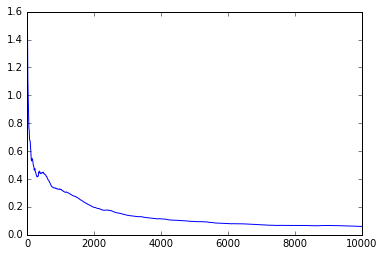

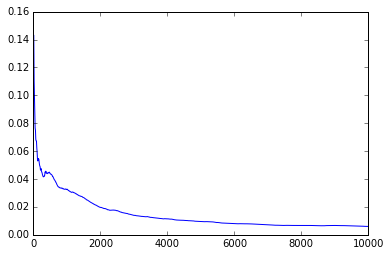

File = 1547831233_2_4
Game = goofspiel_2_4_discard_always
Total iterations = 100000
Check every iteration = 100
---------------------------
Skipping 2 player versions
---------------------------

File = 1547830251_3_3
Game = goofspiel_3_3_discard_always
Total iterations = 100000
Check every iteration = 100
Logged 1000 out of 1000.0 datapoints in 20800.850124835968 seconds (aka 5.778013923565546 hours)
Average duration of batch = 20.800850124835968 seconds (aka 0.005778013923565546 hours)
Solved in 20823.412744045258 seconds
Solved in 347.05687906742094 minutes
Solved in 5.78428131779035 hours
Final utility = [0.9394450000001348, 0.7862116666669178, 1.0736133333336846]
Social welfare = 2.799270000000737
Max social welfare = 6 (obtained 46.654500000012284%)
Average iterations per second = 4.802286792715876


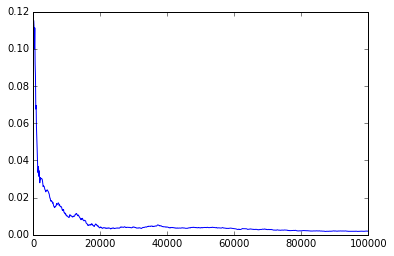

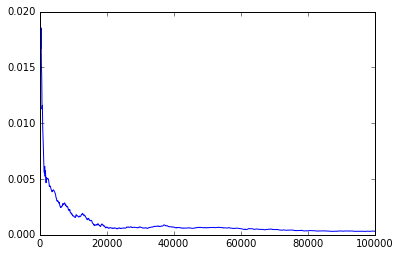

File = 1547904057_3_4
Game = goofspiel_3_4_accumulate
Total iterations = 10000
Check every iteration = 10
Logged 1000 out of 1000.0 datapoints in 73197.77678847313 seconds (aka 20.33271577457587 hours)
Average duration of batch = 73.19777678847313 seconds (aka 0.02033271577457587 hours)
Solved in 73211.93204379082 seconds
Solved in 1220.1988673965136 minutes
Solved in 20.336647789941892 hours
Final utility = [3.3950833333333303, 3.3994958333333356, 3.158579166666671]
Social welfare = 9.953158333333338
Max social welfare = 10 (obtained 99.53158333333339%)
Average iterations per second = 0.13658975689944397


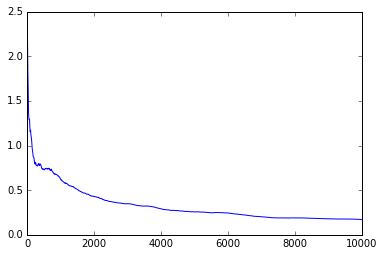

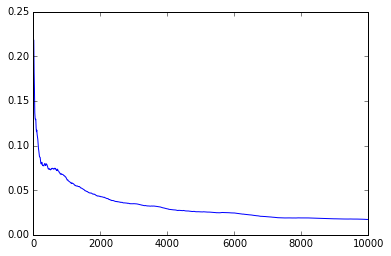

File = 1547830515_3_3
Game = goofspiel_3_3_discard_if_all
Total iterations = 100000
Check every iteration = 100
Logged 1000 out of 1000.0 datapoints in 23311.722905874252 seconds (aka 6.47547858496507 hours)
Average duration of batch = 23.31172290587425 seconds (aka 0.00647547858496507 hours)
Solved in 23342.124170303345 seconds
Solved in 389.0354028383891 minutes
Solved in 6.483923380639818 hours
Final utility = [1.992858333329904, 1.5125433333357579, 2.484279999997767]
Social welfare = 5.989681666663429
Max social welfare = 6 (obtained 99.82802777772383%)
Average iterations per second = 4.284100250277284


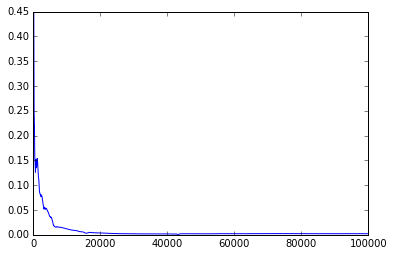

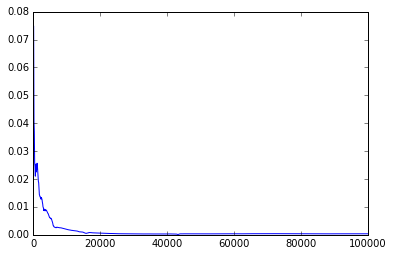

File = 1547916474_2_5
Game = goofspiel_2_5_accumulate
Total iterations = 10000
Check every iteration = 10
---------------------------
Skipping 2 player versions
---------------------------

File = 1547830241_3_2
Game = goofspiel_3_2_discard_always
Total iterations = 100000
Check every iteration = 100
Logged 1000 out of 1000.0 datapoints in 32.14625144004822 seconds (aka 0.008929514288902284 hours)
Average duration of batch = 0.03214625144004822 seconds (aka 8.929514288902284e-06 hours)
Solved in 39.37327337265015 seconds
Solved in 0.6562212228775024 minutes
Solved in 0.010937020381291707 hours
Final utility = [0.0, 0.0, 0.0]
Social welfare = 0.0
Max social welfare = 3 (obtained 0.0%)
Average iterations per second = 2539.793911812854


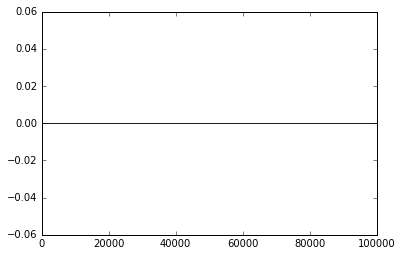

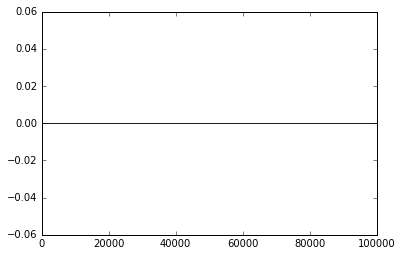

In [238]:
target_epsilons = [10, 5, 2, 1.5, 1, 0.5, 0.2, 0.1, 0.01, 0]
data_per_instance = {}

for name in file_names:
    analyze(name, target_epsilons, data_per_instance)

In [224]:
size_data = {
    'leduc_3_3_3': (684, 1371),
    'leduc_3_3_4': (1200, 2403),
    'leduc_3_3_5': (1860, 3723),
    'leduc_3_3_6': (2664, 5331),
    
    'goofspiel_3_3_accumulate': (194, 396),
    'goofspiel_3_3_discard_if_all': (194, 396),
    'goofspiel_3_3_discard_if_high': (194, 396),
    'goofspiel_3_3_discard_always': (194, 396),
    'goofspiel_3_4_accumulate': (48966, 98523),
    'goofspiel_3_4_discard_if_all': (48966, 98523),
    'goofspiel_3_4_discard_if_high': (48966, 98523),
    'goofspiel_3_4_discard_always': (48966, 98523),
    
    # Random sized are taken from specific dat files
    'random_2_5_2': (24, 46),
    'random_2_6_2': (52, 102),
    'random_2_7_2': (94, 186),
    'random_2_8_2': (186, 370),
    'random_2_9_2': (383, 764),
    'random_2_10_2': (776, 1550),
    'random_3_5_2': (29, 55),
    'random_3_6_2': (49, 95),
    'random_3_7_2': (100, 197),
    'random_3_8_2': (206, 409),
    'random_3_9_2': (378, 753),
    'random_3_10_2': (757, 1541),
}

In [225]:
def count_sequences(cfr_tree):
    all_nodes = reduce(lambda x, y: x + y.nodes, cfr_tree.information_sets.values(), [])
    all_leaves = list(filter(lambda n: n.isLeaf(), reduce(lambda x, y: x + y.children, all_nodes, [])))
    all_nodes = all_nodes + all_leaves
    
    count = 0

    for p in range(cfr_tree.numOfPlayers):
        Q_raw = list(filter(lambda q: q != {}, map(lambda n: n.base_node.getSequence(p), all_nodes)))
        Q = [{}] + [dict(t) for t in {tuple(d.items()) for d in Q_raw}]
        count += len(Q)
        
    return count

def count_infosets(cfr_tree):
    return len(cfr_tree.information_sets)

def get_size_data(par):
    name = parameters_to_string(par)
    if name not in size_data:
        if par['game'] == 'kuhn':
            cfr_tree = CFRTree(build_kuhn_tree(par['players'], par['rank']))
        elif par['game'] == 'leduc':
            cfr_tree = CFRTree(build_leduc_tree(par['players'], par['suits'], par['rank'], 
                                                par['betting_parameters']))
        elif par['game'] == 'goofspiel':
            # Tie solver is not needed to determine the size of the game
            cfr_tree = CFRTree(build_goofspiel_tree(par['players'], par['rank']))
        size_data[name] = (count_infosets(cfr_tree), count_sequences(cfr_tree))
        
    return size_data[name]

In [226]:
from IPython.display import HTML, display
import tabulate

In [227]:
table_text = [['Game', 'Inf.', 'Seq.', 'Delta'] + (list(map(lambda el: str(el) + '%', target_epsilons)))]
for (game, data) in sorted(data_per_instance.items()):
    par = data['parameters']
    
    size = get_size_data(par)
    
    line_text = [game, size[0], size[1]]
    line_text.append(delta_utility(par['game'], par['players'], par['rank'], par['betting_parameters']))
    line_text += list(map(lambda t: 'n/a' if t == -1 else str(t), data['time_to_target']))
    
    table_text.append(line_text)
    
    print(game + " done")

goofspiel_3_2_discard_always done
goofspiel_3_3_accumulate done
goofspiel_3_3_discard_always done
goofspiel_3_3_discard_if_all done
goofspiel_3_3_discard_if_high done
goofspiel_3_4_accumulate done
goofspiel_3_4_discard_always done


In [228]:
display(HTML(tabulate.tabulate(table_text, tablefmt='html')))

Game,Inf.,Seq.,Delta,10%,5%,2%,1.5%,1%,0.5%,0.2%,0.1%,0.01%,0%
goofspiel_3_2_discard_always,4,11,3,0.03103,0.03103,0.03103,0.03103,0.03103,0.03103,0.03103,0.03103,0.03103,0.03103
goofspiel_3_3_accumulate,194,396,6,1.13366,1.13366,1.13366,1.13366,1.13366,1.13366,1.13366,1.13366,48.47719,n/a
goofspiel_3_3_discard_always,194,396,6,0.91012,0.91012,0.91012,0.91012,0.91012,0.91012,0.91012,0.91012,9.84169,n/a
goofspiel_3_3_discard_if_all,194,396,6,2.05096,2.05096,2.05096,2.05096,2.05096,2.05096,2.05096,2.05096,67.25987,n/a
goofspiel_3_3_discard_if_high,194,396,6,0.88156,0.88156,0.88156,0.88156,0.88156,0.88156,0.88156,0.88156,18.46564,n/a
goofspiel_3_4_accumulate,48966,98523,10,23.77046,23.77046,23.77046,23.77046,23.77046,23.77046,43.42575,289.64866,n/a,n/a
goofspiel_3_4_discard_always,48966,98523,10,25.3744,25.3744,25.3744,25.3744,25.3744,25.3744,25.3744,59.73898,19719.77297,n/a


In [133]:
display(HTML(tabulate.tabulate(table_text, tablefmt='html')))

Game,Inf.,Seq.,Delta,10%,5%,2%,1.5%,1%,0.5%,0.2%,0.1%,0.01%,0%
goofspiel_3_3_accumulate,194,396,6,0.05666,0.05666,0.05666,0.05666,0.05666,0.05666,0.11619,0.24677,74.00582,n/a
goofspiel_3_3_discard_always,194,396,6,0.05361,0.05361,0.05361,0.05361,0.05361,0.05361,0.05361,0.10868,16.82631,n/a
goofspiel_3_3_discard_if_all,194,396,6,0.05128,0.05128,0.05128,0.05128,0.05128,0.05128,0.05128,0.55807,36.39605,n/a
goofspiel_3_3_discard_if_high,194,396,6,0.12849,0.12849,0.12849,0.12849,0.12849,0.12849,0.12849,0.54076,119.7753,n/a
goofspiel_3_4_accumulate,48966,98523,10,3.5813,3.5813,3.5813,3.5813,3.5813,3.5813,21.20774,n/a,n/a,n/a
goofspiel_3_4_discard_always,48966,98523,10,3.67315,3.67315,3.67315,3.67315,3.67315,3.67315,3.67315,233.51398,n/a,n/a
goofspiel_3_4_discard_if_all,48966,98523,10,3.57475,3.57475,3.57475,3.57475,3.57475,7.02065,45.4337,n/a,n/a,n/a
goofspiel_3_4_discard_if_high,48966,98523,10,3.65502,3.65502,3.65502,3.65502,3.65502,3.65502,17.88899,477.02367,n/a,n/a


### Table for number of iterations instead of running time

In [229]:
table_text2 = [['Targets'] + (list(map(str, target_epsilons)))]
for (game, data) in sorted(data_per_instance.items()):
    line_text = [game] + list(map(lambda t: 'n/a' if t == -1 else str(t), data['iterations_to_target']))
    table_text2.append(line_text)

In [230]:
display(HTML(tabulate.tabulate(table_text2, tablefmt='html')))

Targets,10,5,2,1.5,1,0.5,0.2,0.1,0.01,0
goofspiel_3_2_discard_always,100,100,100,100,100,100,100,100,100,100
goofspiel_3_3_accumulate,100,100,100,100,100,100,100,100,2300,n/a
goofspiel_3_3_discard_always,100,100,100,100,100,100,100,100,900,n/a
goofspiel_3_3_discard_if_all,100,100,100,100,100,100,100,100,2900,n/a
goofspiel_3_3_discard_if_high,100,100,100,100,100,100,100,100,1500,n/a
goofspiel_3_4_accumulate,10,10,10,10,10,10,20,150,n/a,n/a
goofspiel_3_4_discard_always,10,10,10,10,10,10,10,30,4730,n/a


---

goofspiel_3_4_accumulate
goofspiel_3_4_accumulate
goofspiel_3_4_accumulate


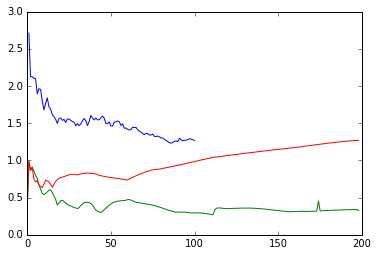

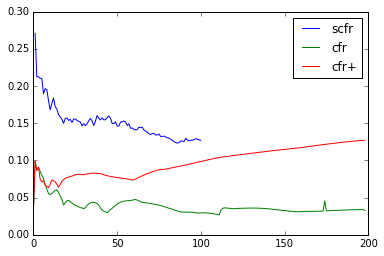

In [54]:
filename = 'results/remote/goofspiel_short_20190121/1548066333_3_4'
filename_cfr = 'results/remote/goofspiel_cfr_20190121/1548066663_3_4'
filename_cfr_plus = 'results/remote/goofspiel_cfr_plus_20190121/1548066631_3_4'

file = open(filename, "r")
data = json.load(file)
file.close()

file_cfr = open(filename_cfr, "r")
data_cfr = json.load(file_cfr)
file_cfr.close()

file_cfr_plus = open(filename_cfr_plus, "r")
data_cfr_plus = json.load(file_cfr_plus)
file_cfr_plus.close()

print(parameters_to_string(data['parameters']))
print(parameters_to_string(data_cfr['parameters']))
print(parameters_to_string(data_cfr_plus['parameters']))

durations = list(map(lambda el: el['duration'], data['data']))
durations_cfr = list(map(lambda el: el['duration'], data_cfr['data']))
durations_cfr_plus = list(map(lambda el: el['duration'], data_cfr_plus['data']))

du = delta_utility(data['parameters']['game'], data['parameters']['players'], data['parameters']['rank'],
               data['parameters']['betting_parameters'])
du_cfr = delta_utility(data_cfr['parameters']['game'], data_cfr['parameters']['players'], 
                       data_cfr['parameters']['rank'], data_cfr['parameters']['betting_parameters'])
du_cfr_plus = delta_utility(data_cfr_plus['parameters']['game'], data_cfr_plus['parameters']['players'], 
                       data_cfr_plus['parameters']['rank'], data_cfr_plus['parameters']['betting_parameters'])

iteration_counts = list(map(lambda el: el['iteration_number'], data['data']))
epsilons = list(map(lambda el: max(0, -min(el['epsilon'])), data['data']))
percent_epsilons = list(map(lambda el: el / du, epsilons))
iteration_counts_cfr = list(map(lambda el: el['iteration_number'], data_cfr['data']))
epsilons_cfr = list(map(lambda el: max(0, -min(el['epsilon'])), data_cfr['data']))
percent_epsilons_cfr = list(map(lambda el: el / du_cfr, epsilons_cfr))
iteration_counts_cfr_plus = list(map(lambda el: el['iteration_number'], data_cfr_plus['data']))
epsilons_cfr_plus = list(map(lambda el: max(0, -min(el['epsilon'])), data_cfr_plus['data']))
percent_epsilons_cfr_plus = list(map(lambda el: el / du_cfr_plus, epsilons_cfr_plus))

plt.plot(iteration_counts, epsilons)
plt.plot(iteration_counts_cfr, epsilons_cfr)
plt.plot(iteration_counts_cfr_plus, epsilons_cfr_plus)
plt.show()
plt.plot(iteration_counts, percent_epsilons)
plt.plot(iteration_counts_cfr, percent_epsilons_cfr)
plt.plot(iteration_counts_cfr_plus, percent_epsilons_cfr_plus)
plt.legend(['scfr','cfr', 'cfr+'])
plt.show()